In [1]:
import copy
import os.path as osp

import sys
sys.path.append('./cam2')

import click
import cv2
import matplotlib.cm as cm
import numpy as np
import torch
import torch.hub
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import models, transforms

from grad_cam import (
    BackPropagation,
    Deconvnet,
    GradCAM,
    GuidedBackPropagation,
    occlusion_sensitivity,
)

from main import get_device, get_classtable

# import resnet34 for dr classification
sys.path.append('/home/zhangwd/code/work/xrayproduct/drCls/train/')
from resnet import *
from dr_model import *
os.environ['CUDA_VISIBLE_DEVICES']='6'

import matplotlib.pyplot as plt

In [2]:
model = DRModel('rsn34', 1024, 2)

In [3]:
weights_file = '/home/zhangwd/code/work/xrayproduct/drCls/train/dr_cls_yyy/ct_pos_recognition_0010_best.pth'
model.load_state_dict(torch.load(weights_file))

<All keys matched successfully>

In [4]:
model = torch.nn.DataParallel(model).cuda()
model.eval()

DataParallel(
  (module): DRModel(
    (base): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-0

In [5]:
target_layers = ["relu", "layer1", "layer2", "layer3", "layer4"]
target_class = 2

In [6]:
def preprocess(image_path):
    raw_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    raw_image = cv2.resize(raw_image, (1024,1024))
    img1 = raw_image.copy()
    img1 = np.array(img1, dtype=np.float)
    img1 = img1
    print(img1.max())
    input_img = torch.from_numpy(img1)
    input_img = torch.unsqueeze(input_img, 0)
    return input_img, raw_image


# image_paths = ['./cam2/samples/cat_dog.png']
image_paths = ['/home/zhangwd/code/work/xrayproduct/chestx-ray8/lib/chexnet/test1/00009285_000.png']
images = []
raw_images = []
print("Images:")
for i, image_path in enumerate(image_paths):
    print("\t#{}: {}".format(i, image_path))
    image, raw_image = preprocess(image_path)
    images.append(image)
    raw_images.append(raw_image)
images = torch.stack(images)
images = images.float().cuda()
print(images.shape)

Images:
	#0: /home/zhangwd/code/work/xrayproduct/chestx-ray8/lib/chexnet/test1/00009285_000.png
255.0
torch.Size([1, 1, 1024, 1024])


In [7]:
# classes = get_classtable()

In [8]:
gcam = GradCAM(model=model)
probs, ids = gcam.forward(images)

In [9]:
target_class = 0
ids_ = torch.LongTensor([[target_class]] * len(images)).cuda()

In [10]:
print(probs)

tensor([[1., 0.]], device='cuda:0', grad_fn=<SortBackward>)


In [11]:
gcam.backward(ids=ids_)

In [12]:
def get_device(cuda):
    cuda = cuda and torch.cuda.is_available()
    device = torch.device("cuda" if cuda else "cpu")
    if cuda:
        current_device = torch.cuda.current_device()
        print("Device:", torch.cuda.get_device_name(current_device))
    else:
        print("Device: CPU")
    return device
device = get_device(True)
print(device)

Device: GeForce GTX 1080 Ti
cuda


In [13]:
def save_gradcam(filename, gcam, raw_image, paper_cmap=True):
    gcam = gcam.cpu().numpy()
    cmap = cm.jet_r(gcam)[..., :3]*255
    img_rgb = cv2.cvtColor(raw_image, cv2.COLOR_GRAY2RGB)
    if paper_cmap:
        alpha = gcam[..., None]
        gcam = alpha * cmap + (1 - alpha) * img_rgb
    else:
        gcam = (cmap.astype(np.float) + img_rgb.astype(np.float)) / 2
    cv2.imwrite(filename, np.uint8(gcam))

In [14]:

    
    target_layers = ["module.base.2", "module.base.4", "module.base.5", "module.base.6", "module.base.7"]
    output_dir = './xxx' 
    os.makedirs(output_dir, exist_ok=True)
    for target_layer in target_layers:
        print("Generating Grad-CAM @{}".format(target_layer))

        # Grad-CAM
        regions = gcam.generate(target_layer=target_layer)
        print('regions:')
        print(regions.shape)

        for j in range(len(images)):
#             print(
#                 "\t#{}: {} ({:.5f})".format(
#                     j, classes[target_class], float(probs[ids == target_class])
#                 )
#             )

            save_gradcam(
                filename=osp.join(
                    output_dir,
                    "{}-{}-gradcam-{}-{}.png".format(
                        j, "resnet152", target_layer, 'xxx'
                    ),
                ),
                gcam=regions[j, 0],
                raw_image=raw_images[j],
            )

Generating Grad-CAM @module.base.2
regions:
torch.Size([1, 1, 1024, 1024])
Generating Grad-CAM @module.base.4
regions:
torch.Size([1, 1, 1024, 1024])
Generating Grad-CAM @module.base.5
regions:
torch.Size([1, 1, 1024, 1024])
Generating Grad-CAM @module.base.6
regions:
torch.Size([1, 1, 1024, 1024])
Generating Grad-CAM @module.base.7
regions:
torch.Size([1, 1, 1024, 1024])


In [15]:
# for name, module in model.named_modules():
#     print(name)

In [16]:
rsn_model = torchvision.models.resnet34()

In [17]:
# for name, module in rsn_model.named_modules():
#     print(name)

In [18]:
# dir(model)

In [19]:
# model.state_dict

In [20]:
# rsn_model.state_dict

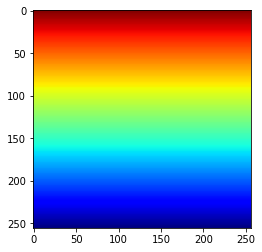

In [21]:
heatmap = np.arange(256*256)/256/256

heatmap = np.resize(heatmap, [256,256])
heatmap = cm.jet_r(heatmap)
plt.figure()
plt.imshow(heatmap)